# Deep Learning
The _objectives_ in the following `Notebook` are:

1. Perform Machine Learning Modelling using <code style="background:yellow;color:black">Random Forest, RNN & LSTM based architecture</code> by proper analysis and description. 
2. Generating features with the help of feature engineering as in the case of DL the loss is very different.
3. Perform Comparision by models and trying to find the best one with the help of our metric function.


__Some important points:__
- For solving this problem we will be following the steps discussed in the NB and for explaining the observation `boxes` willl be used


<div class="alert alert-block alert-danger">
    
<b>Caution:</b>
    
Due to `complex architecture and low memory in system` we will not train our model extensively.
    
</div>


> Since we now want to predict the __‘Category_Reporting’__ for rest of the month Of May we have to build a model based on our data so far. We will try to model the distribution so far.

## Getting requirements ready

In [1]:
# run the libraries
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
from termcolor import colored
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from collections import Counter
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, TimeDistributed, Flatten,Input,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, power_transform
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score,classification_report,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
%matplotlib inline
%run viz.py
%load_ext tensorboard

In [2]:
# read the data and see it....
df = pd.read_csv('EMP_Cleaned_File.csv')
df.head()

,CustomerHash,OrderHash,Date_Order,Customer_Age,Gender,Account_Age,AffinityProductGender,Category_Reporting,Genre,ClientType,...,Delivery_Value,Discount_Total,OrderProfit,Day,Month,Day_Sin,Day_Cos,Month_Sin,Month_Cos,cluster
0,0x3093AB3CF6C717566C0034C1D4600E64D9B01773,0xBF46DF9D1097824DE975E4BAC3D34FDE621BE3A6,2019-11-08,38.0,2,14,Male,Entertainment - Apparel,Merchandise - Film & TV,desktop,...,52.92,0.00,5.6053,5,11,-9.749279e-01,-0.222521,-0.5,0.866025,2
1,0x3820FA6A7E1D368E7846B8ED85AC48C83F552D96,0x85C8363C9DDFFF16DF84926428B6A72822226FE6,2019-11-10,45.0,0,1,Male,Fashion / Private label - Apparel,Private label,app,...,88.20,0.00,35.7781,7,11,-2.449294e-16,1.000000,-0.5,0.866025,0
2,0xA803C4F8AF9AEBEC2620412EB7BEFBB1F6B14E70,0x92F575557F8EC463F61EFEC7DAF97798C222FC62,2019-11-10,30.0,3,0,Unisex,Entertainment - Apparel,Merchandise - Film & TV,mobile,...,212.55,-39.49,99.1710,7,11,-2.449294e-16,1.000000,-0.5,0.866025,1
3,0x49988EA0FE66BAA42E97123D0EB806486EF84ABD,0x197258C2B7CB93A8C3101C58C31BF2159A1849F3,2019-11-10,41.0,3,10,Female,Fashion / 3rd Party - Apparel,3rd Party Brands,app,...,45.70,-46.73,-5.7816,7,11,-2.449294e-16,1.000000,-0.5,0.866025,1
4,0xDDC4EBF5B1B7143B80790D2C476DC821E97D8AD9,0xC9806A9D99B442B47163EC27546F7BF35EA535D7,2019-11-10,42.0,0,3,Male,Fashion / Private label - Apparel,Private label,desktop,...,141.13,0.00,42.7255,7,11,-2.449294e-16,1.000000,-0.5,0.866025,0


## Data Cleaning
In this we will perfrom 3 main steps:

1. Select relevant features.
2. Normalise the continous variable and `transform` the categorical variable .
3. Perform standard scaling and prepare the data for modelling.

### Feature selection

> We have selected some features from the data based on our understanding of `domain and necessary relations` for classification of models.


> We will use this features for our prediction task.

In [3]:
## feature selection
features    = ['Customer_Age','OrderValue','Revenue_Goods','Delivery_Value','Day_Sin','Day_Cos','Month_Sin','Month_Cos','Gender','Category_Reporting','Marketing_Channel','cluster']


## categorical features
cat_features = ['Gender','Marketing_Channel']

### Label encoding categorical variables

In [4]:
## make the encoding
ord_enc = LabelEncoder()

for i in cat_features:
    df[i] = LabelEncoder().fit_transform(df[i])

## for getting values again of prediction we will make an instance
le = LabelEncoder()
df['Category_Reporting'] = le.fit_transform(df['Category_Reporting'].values)

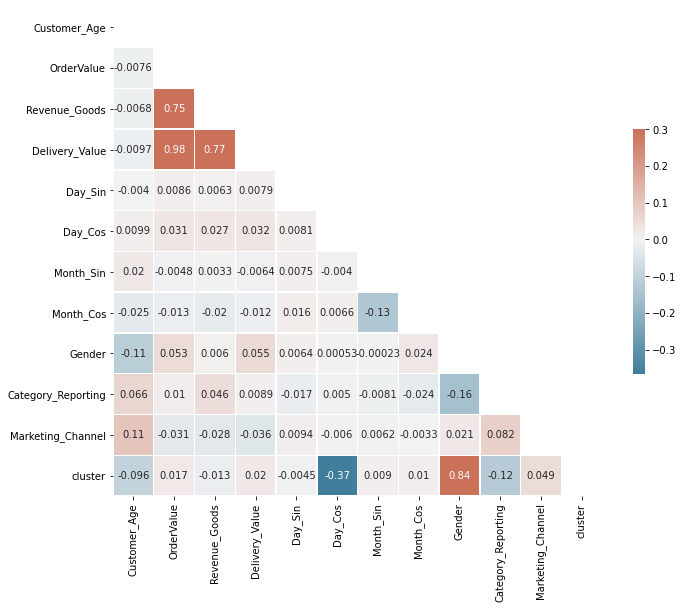

In [5]:
## let us see plot
visualisation(df[features]).heat_map()

### Normalisation of value

In [6]:
## get the values
X = df[features]
X = X.drop(columns = ['Category_Reporting']).values
y = df['Category_Reporting'].values

In [7]:
## normalise the values
scaler = MinMaxScaler(feature_range=(0, 1))
X      = scaler.fit_transform(X)

```python
## apply box cox transformation
X = power_transform(X, method='yeo-johnson')
y = power_transform(X, method='yeo-johnson')
```

### Metrics

Since we are mostly concerned with accuracy we will check four accuracy metrics:
- Precision
- Recall
- Accuracy
- F1 Score

In [8]:
def calc_metrics_class(pred,y_test):
        # Print's the model's performance overall
        print(colored("Generating the results wait for it....",color = 'red', attrs=['bold']))
        # Lets see the classification metrics
        precision = precision_score(pred, y_test,average='weighted')
        recall = recall_score(pred,y_test,average='weighted')
        f1 = f1_score(pred,y_test,average='weighted')
        accuracy = accuracy_score(pred,y_test)

        print('Precision:', precision)
        print('Recall:',  recall)
        print('Accuracy:', accuracy)
        print('F1 Score:', f1)

## Class balance

In [9]:
## let us see class distribution
Counter(y)

Counter({2: 576381,
         5: 510595,
         4: 689434,
         1: 276979,
         12: 557520,
         7: 208431,
         10: 214678,
         11: 87050,
         0: 188975,
         9: 82378,
         3: 235899,
         8: 52474,
         13: 48278,
         6: 1006})

<div class="alert alert-block alert-info">
<b>Data Balance:</b> We see our data is not at all balanced. For this purpose we specifically assign weights to our corresponding labels. We do so, by giving higher weight to labels having low frequency and lower to labels having more frequency.</div>

In [10]:
## compute class weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(y), y)
class_weight = dict(enumerate(class_weight))

## ML Model

The machine learning model which we will be using is `Random Forest` for baseline accuracy and we will then go to __Deep Learning__ for more accuracy

In [11]:
## Random Forest with Best Params
def random_forest(X_train,y_train,X_test,y_test):
    print(colored("Performing modelling for Random forest",color = 'green', attrs=['bold']))
    # Create Random Forest Model
    rf_model = RandomForestClassifier(random_state=1)
    # Specifying hyperparams for the search(narrowed it down due to computation)
    param_grid = {
            'n_estimators': [10],
            'max_features': [0.3],
            'min_samples_split': [3],
            'class_weight' : [class_weight]
            }
    # Fit the model and find best hyperparams
    grid_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_model.fit(X_train,y_train)

    # Fit the model with best params
    print("Best parameters =", grid_model.best_params_)
    model_clf = rf_model.set_params(**grid_model.best_params_)
    model_clf.fit(X_train, y_train)

    # Time to test the model
    # Time to test the model for test set
    print(colored("Test results for test set",color = 'yellow', attrs=['bold']))
    pred = model_clf.predict_proba(X_test).astype(float)
    
    ## predict the results
    calc_metrics_class(pred,y_test)

    # Returning model
    return model_clf

In [12]:
## split the data for better accuracy
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2,random_state=True)

> Skipping due to low __RAM__ issues

In [13]:
## model of random forest
#rf = random_forest(X_train,y_train,X_test,y_test)

<div class="alert alert-block alert-warning">

We set a __baseline accuracy__ to begin with and hope for much better results as we move towards sequence based models.

</div>

## Deep Learning

### Data Tranform

<div class="alert alert-block alert-info">
<b>Code:</b> Since the models which we are using use sequence to sequence encoding we need to take care of shape of our data. The transformation of data is important in this case. For this purpose we will use the custom window to transform the data from 2D to 3D.</div>


In [14]:
def lstm_data_transform(x_data, y_data, num_steps=1):
    """ 
    Changes data to the format for LSTM training for sliding window approach 
    
    This function reshape for lstm into 3 dimension shape (batchsize, timestep, features)

    Input to this function is X and y and time step
    """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    
    return x_array, y_array

In [15]:
## transform for LSTM
X_, y_ = lstm_data_transform(X, y, num_steps=2)

In [16]:
## train and test split
X_train, X_test, y_train, y_test =  train_test_split(X_, y_, test_size=0.2,random_state=True)

## Modelling

Two Types of Deep Learning model used here to train the sequential data are:

1. `RNN Model:` The reason to choose this model was to check what is the effect of sequence transformation with the introduction of the <code style="background:yellow;color:black">previous cell state.</code> Our hypothesis is it captures the temporal relationship of our data well.


2. `LSTM Model`: This adds to the RNN model with an extra `Forget Gate` which yields better accuracy.

> This model works well when we have more training data. But in our case, we have less data so let's see how well it performs.


### RNN Model

In [17]:
## define our params
layers = [150,100]
dense_layer = [500,200]
dropout = 0.4

In [18]:
## declare the shape
inp = Input(shape=X_train.shape[1:])

## RNN layer
x = SimpleRNN(layers[0], return_sequences=True)(inp)  # add first layer
x = Dropout(dropout)(x)

## Repeat based on values in list with dropout
for i in layers[1:] : 
    x = SimpleRNN(i, activation='relu', return_sequences=True)(x) # add succesiive layers
    x = Dropout(dropout)(x)  # add dropout for layer

## Activate the neuron
x = Activation("relu")(x)

## flatten and add dense layer
x = Flatten()(x)
for i in dense_layer:
    x = Dense(i,activation='relu')(x)  

# add output layer
y = Dense(len(np.unique(y_train).tolist()), activation='softmax')(x)  # output layer with linear activation


## Instantiate the model
rnn_model = Model(inp,y)

## Set ADAM opt and see the model
opt = Adam(lr = 0.001)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 11)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2, 150)            24300     
_________________________________________________________________
dropout (Dropout)            (None, 2, 150)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 100)            25100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
activation (Activation)      (None, 2, 100)            0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0     

In [19]:
# Create a checkpoint for models
checkpoint = tf.keras.callbacks.ModelCheckpoint("RNN.h5",monitor="val_mse",verbose = 1,        # creating a callback for saving the model
                                                save_best_only = False,save_weights_only = False, # save the weights
                                                mode= "auto",save_freq= "epoch",                  
                                                options=None)

# tensorboard logs
# Define Tensorboard as a Keras callback
tensorboard = TensorBoard(
  log_dir='.\RNN_logs', histogram_freq=0,write_graph=True, 
  write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
  embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
keras_callbacks = [tensorboard]


## fit and train
rnn_model.fit(X_train,y_train, epochs=1, batch_size=512,validation_data= (X_test,y_test),class_weight = class_weight,
              callbacks = [checkpoint,keras_callbacks])

5829/5829 [==============================] - 139s 23ms/step - loss: 2.5518 - accuracy: 0.0568 - val_loss: 2.6235 - val_accuracy: 0.0363

Epoch 00001: saving model to RNN.h5


In [20]:
## let us see the accuracy
## get the pred and the y_test
pred = np.argmax(rnn_model.predict(X_test),axis = 1).flatten().tolist()
## predict the results
calc_metrics_class(pred,y_test)

Generating the results wait for it....
Precision: 0.3387782681104985
Recall: 0.03629412773988762
Accuracy: 0.03629412773988762
F1 Score: 0.04951594088994364


In [21]:
%tensorboard --logdir=RNN_logs

Reusing TensorBoard on port 6006 (pid 11628), started 0:30:55 ago. (Use '!kill 11628' to kill it.)

## LSTM

In [22]:
## define our params
layers = [175,50]
dense_layer = [125,75]
dropout = 0.5

In [23]:
## declare the shape
inp = Input(shape=X_.shape[1:])

## LSTM layer
x = LSTM(layers[0], return_sequences=True)(inp)  # add first layer

## Repeat based on values in list with dropout
for i in layers[1:] : 
    x = LSTM(i, activation='relu', return_sequences=True)(x) # add succesiive layers
    x = Dropout(dropout)(x)  # add dropout for first layer
    
## adding time distributed layer
x = TimeDistributed(Dense(5))(x)  # add dense layer
x = Activation("relu")(x)

## flatten and add dense layer
x = Flatten()(x)
for i in dense_layer:
    x = Dense(i,activation='relu')(x)  # add output layer

# add output layer
y = Dense(len(np.unique(y_train).tolist()), activation='softmax')(x)  # output layer with linear activation


## Instantiate the model
lstm_model = Model(inp,y)

## Set ADAM opt and see the model
opt = Adam(lr = 0.001)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 11)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 2, 175)            130900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 50)             45200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 50)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 5)              255       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0   

In [24]:
# Create a checkpoint for models
checkpoint = tf.keras.callbacks.ModelCheckpoint("LSTM.h5",monitor="val_mse",verbose = 1,        # creating a callback for saving the model
                                                save_best_only = False,save_weights_only = False, # save the weights
                                                mode= "auto",save_freq= "epoch",                  
                                                options=None)

# tensorboard logs
# Define Tensorboard as a Keras callback
tensorboard = TensorBoard(
  log_dir='.\LSTM_logs', histogram_freq=0,write_graph=True, 
  write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
  embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
keras_callbacks = [tensorboard]


lstm_model.fit(X_train,y_train, epochs=1, batch_size=512,validation_data= (X_test,y_test),class_weight = class_weight,
               callbacks = [checkpoint,keras_callbacks])

5829/5829 [==============================] - 191s 32ms/step - loss: 2.5354 - accuracy: 0.0605 - val_loss: 2.6305 - val_accuracy: 0.0384

Epoch 00001: saving model to LSTM.h5


In [25]:
## let us see the accuracy
## get the pred and the y_test
pred = np.argmax(lstm_model.predict(X_test),axis = 1).flatten().tolist()
## predict the results
calc_metrics_class(pred,y_test)

Generating the results wait for it....
Precision: 0.36200026014277426
Recall: 0.03839059752069661
Accuracy: 0.03839059752069661
F1 Score: 0.05290858013586134


In [26]:
%tensorboard --logdir=LSTM_logs

Reusing TensorBoard on port 6006 (pid 23788), started 0:56:04 ago. (Use '!kill 23788' to kill it.)

<div class="alert alert-block alert-warning">

</div>

## Prediction for May


Now we will see the prediction of our Model for the `Month of May`

In [27]:
## read it again
df = pd.read_csv('EMP_Cleaned_File.csv')

In [28]:
## lets get datetime based order
df['Date_Order']         = pd.to_datetime(df['Date_Order'])
df['month_cuttoff']      = [int(i.strftime('%m')) for i in df['Date_Order']]

In [29]:
## get the data for the month of may
df = df[df['month_cuttoff'] == 5].reset_index(drop=True)

In [30]:
## feature selection
features    = ['Customer_Age','OrderValue','Revenue_Goods','Delivery_Value','Day_Sin','Day_Cos','Month_Sin','Month_Cos','Gender','Category_Reporting','Marketing_Channel','cluster']


## categorical features
cat_features = ['Gender','Marketing_Channel']

In [31]:
## make the encoding
ord_enc = LabelEncoder()

for i in cat_features:
    df[i] = LabelEncoder().fit_transform(df[i])

## for getting values again of prediction we will make an instance
le = LabelEncoder()
df['Category_Reporting'] = le.fit_transform(df['Category_Reporting'].values)

In [32]:
## get the values
X = df[features]
X = X.drop(columns = ['Category_Reporting']).values
y = df['Category_Reporting'].values

In [33]:
## normalise the values
scaler = MinMaxScaler(feature_range=(0, 1))
X      = scaler.fit_transform(X)

In [34]:
## transform for LSTM
X, y = lstm_data_transform(X, y, num_steps=2)

_Get the prediction right and get the job!!_

In [35]:
## get the predictions
predict_lstm= np.argmax(lstm_model.predict(X),axis = 1).flatten().tolist()
predict_lstm= le.inverse_transform(predict_lstm)

Counter(predict_lstm)

Counter({'Funshirts&Hoodies - Apparel': 275888,
         'Freebies': 5576,
         'Music - Apparel': 1})

In [36]:
## get the predictions
predict_rnn= np.argmax(rnn_model.predict(X),axis = 1).flatten().tolist()
predict_rnn= le.inverse_transform(predict_rnn)

Counter(predict_rnn)

Counter({'Fashion - Accessories': 179281,
         'Funshirts&Hoodies - Apparel': 102184})

<div class="alert alert-block alert-info">
<b>Prediction:</b> 
    
I predict customers will be more interested in `Funshirts & Hoodies - Apparel and Fashion - Accessories` in May 2021.
    
</div>

<div class="alert alert-block alert-success">
<b>Success:</b> 
Both these models gives us better accuracy and results and I finally wait for our prediction to be accurate this summer to get a job...... :)
</div>